# Logistic regression

In [187]:
%pylab inline
import pandas as pd
import numpy as np

def calculate_norm_dif(x):
    i=x.decode("utf8")
    sum_m_f=float(int(googlenumber[i][0])+int(googlenumber[i][1]))
    return (float(googlenumber[i][0])-float(googlenumber[i][1]))/sum_m_f if sum_m_f!=0 else 0
def reject_outliers2(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
def check_outlier(x,mean,std):
    if abs(x - mean) < 2.0 * std :
        return x

def load_data(bias=True):
    df=pd.read_csv("de/all_data_bias_labour_gender_all_persons.csv",sep="\t",index_col=0)
    df2=df[["labor_market_woman","Bias"]]
    df2=df2.dropna()
    df2.drop(["Apothekerin","Botin","Bundeskanzlerin","Diakonin","Direktrice","Politesse","Hostess","Magd",
         "Mannequin","Nonne","Ordensschwester","Taxifahrerin"],inplace=True)
    print len(df),len(df2)
    df2["Bias2"]=df2.Bias.apply(lambda x: 0 if x=="male" else 1 if x=="neutral" else 2 )
    df2["WikiName"]=df2.index
    page_name=pd.DataFrame.from_csv("de/wiki/all_wiki_pages.csv",sep="\t")
    page_name=page_name.drop("Bias",1)
    df2=pd.merge(df2,page_name, on="WikiName",how="inner",right_index=True)#.drop_columns("Bias_y")
    df2["Profession_name"]=df2.apply(lambda x:  x.Oppositgender if x.Bias=="female" else x.Name,axis=1)
    df2["NormalizedGoogleDif"]=df2.Profession_name.apply(lambda x: calculate_norm_dif(x) if googlenumber.has_key(x.decode("utf8")) else None)
    df2=df2[~df2.NormalizedGoogleDif.isnull()] 
    if bias:
        df2["l_m_without_outliers"]=df2.apply(lambda x: check_outlier(x.labor_market_woman,
                                            df2[df2.Bias2==x.Bias2].labor_market_woman.mean(),
                                         df2[df2.Bias2==x.Bias2].labor_market_woman.std()) ,axis=1)
        df2["NormalizedGoogleDif2"]=df2.apply(lambda x: check_outlier(x.NormalizedGoogleDif,
                                            df2[df2.Bias2==x.Bias2].NormalizedGoogleDif.mean(),
                                         df2[df2.Bias2==x.Bias2].NormalizedGoogleDif.std()) ,axis=1)
    else:
        df2["l_m_without_outliers"]=df2.apply(lambda x: check_outlier(x.labor_market_woman,
                                            np.mean(df2[df2.Bias2==x.Bias2].labor_market_woman.values),
                                         np.std(df2[df2.Bias2==x.Bias2].labor_market_woman.values)) ,axis=1)
        df2["NormalizedGoogleDif2"]=df2.apply(lambda x: check_outlier(x.NormalizedGoogleDif,
                                            np.mean(df2[df2.Bias2==x.Bias2].NormalizedGoogleDif.values),
                                         np.std(df2[df2.Bias2==x.Bias2].NormalizedGoogleDif.values)) ,axis=1)
    df2=df2[(~df2.l_m_without_outliers.isnull())&(~df2.NormalizedGoogleDif2.isnull())]
    df2.to_csv("de/predict_GoogleDif_labor_market.csv")
    return df2


#print abs(32.042925 - df2[df2.Bias2==2].labor_market_woman.mean())
#print abs(32.042925 - np.mean(df2[df2.Bias2==2].labor_market_woman.values))
#print 2 * df2[df2.Bias2==2].labor_market_woman.std()
#print 2 * np.std(df2[df2.Bias2==2].labor_market_woman.values)


#Male bias: 812 , Female bias: 6 , No bias: 19 All: 837

In [127]:
%pylab inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,confusion_matrix,classification_report
from sklearn.cross_validation import train_test_split 
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_curve, auc
from statsmodels.tools import categorical
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import pandas as pd
import numpy as np


def predict_model(df_df,predict_case,remove=False,train_split=True):
    
    
    if remove=="neutral":
        df_df=df_df[(df_df["Bias2"]==0)|(df_df["Bias2"]==2)]
    elif remove=="male":
        df_df=df_df[(df_df["Bias2"]==1)|(df_df["Bias2"]==2)]
    df_df["Bias2"]=df_df.Bias.apply(lambda x: 1 if x==predict_case else 0 )
    
    data = df_df[["l_m_without_outliers","NormalizedGoogleDif2","Bias2"]]
    data=sm.add_constant(data, prepend=False)
    
    y=data['Bias2']
    X=data[["l_m_without_outliers","NormalizedGoogleDif2"]]
    X=sm.add_constant(X, prepend=False)
    X=X.rename(columns = {'const':'intercept'})
 
    if train_split==True:
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
        print len(X_train), len(X_test), len(X_train) + len(X_test)
    else:
        X_train,Y_train=X,y
    res1=sm.Logit(Y_train, X_train) 
    mlogit_res = res1.fit()
    print mlogit_res.params
    print mlogit_res.summary()
    print mlogit_res.pred_table()
    acc=float(sum(mlogit_res.pred_table().diagonal()))/float(len(Y_train))
    print "Accuracy:",acc
    print "Odds:\n", np.exp(mlogit_res.params)
    print "p:\n", np.exp(mlogit_res.params)/(1+np.exp(mlogit_res.params))

    return mlogit_res,data,X_train,Y_train


Populating the interactive namespace from numpy and matplotlib


In [188]:
df_df=load_data(bias=False)

885 859


In [165]:
import scikits.bootstrap as boot
from sklearn.linear_model import LogisticRegression
#====== predict female!!!!!    

#data = df_df[(df_df["Bias2"]==1)|(df_df["Bias2"]==2)]
data=df_df[["l_m_without_outliers","NormalizedGoogleDif2","Bias2","Bias"]]
data["Bias2"]=data.Bias.apply(lambda x: 1 if x=="female" else 0 )



y=data['Bias2'].values.reshape((len(data),1))
X=data[["l_m_without_outliers","NormalizedGoogleDif2"]].values.reshape((len(data),2))

X_train=X[:,:]
Y_train=y[:,:]
model = LogisticRegression(C=1e5)
model = model.fit(X_train,Y_train.ravel())
print "Coef:", model.coef_[0]," intercept:",model.intercept_[0]
ci_p_val_z_score_scikit(model,X_train)

Coef: [  1.02744038 -49.83521435]  intercept: -97.5001883706
Standard errors:  [ 88.35911882   0.935471    46.33579888]
Wald statistics:  [ 1.21760986  1.20629242  1.15674958]
p_val coef 0.272067642664
p_val coef 0.282140670121
p_val intercep 0.269830227941
17.4783600338
0.446604088382
t = 1.09831344569
p_val: 0.272067642664
CI:
-0.806082785158 2.86096354625


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


===== new fold
Coef: [  0.43528202 -16.9167843 ]  intercept: -42.2548250784
1.0


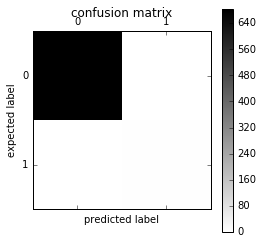

[[685   0]
 [  0   4]]
Standard errors:  [ 45.30949776   0.49027428  20.7849941 ]
Wald statistics:  [ 0.86970931  0.78824865  0.66242362]
p_val coef 0.374630221367
p_val coef 0.415705614477
p_val intercep 0.351035795972
4.03989871056
0.591167683608
t = 0.887833683349
p_val: 0.374630221367
CI:
-0.525655573211 1.39621962002
===== new fold
Coef: [  1.00158705 -48.68718032]  intercept: -95.0777151303
1.0


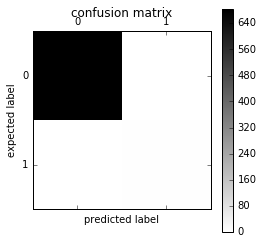

[[685   0]
 [  0   5]]
Standard errors:  [ 85.79928163   0.90780403  45.23539282]
Wald statistics:  [ 1.22797682  1.21728758  1.15843725]
p_val coef 0.269893623417
p_val coef 0.281789876433
p_val intercep 0.267800859175
16.1332595318
0.459457493774
t = 1.10330756288
p_val: 0.269893623417
CI:
-0.777708846853 2.78088295057
===== new fold
Coef: [  0.95243838 -46.14233386]  intercept: -90.3996132045
1.0


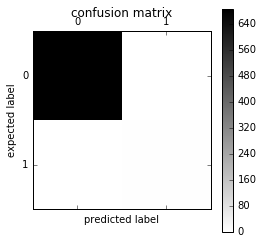

[[686   0]
 [  0   4]]
Standard errors:  [ 80.98230323   0.85745191  42.49562544]
Wald statistics:  [ 1.2461      1.23382689  1.17899147]
p_val coef 0.266664087466
p_val coef 0.277561407579
p_val intercep 0.264298665704
13.9160678176
0.48279296339
t = 1.11077760717
p_val: 0.266664087466
CI:
-0.728167364451 2.63304413063
===== new fold
Coef: [  1.0277503  -49.82434586]  intercept: -97.524296091
1.0


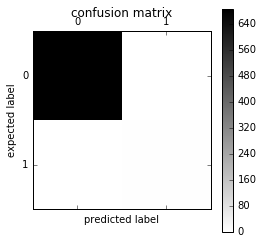

[[686   0]
 [  0   5]]
Standard errors:  [ 88.40651676   0.93608812  46.3111043 ]
Wald statistics:  [ 1.21690616  1.20542935  1.15747851]
p_val coef 0.272239220122
p_val coef 0.2819890893
p_val intercep 0.269968674976
17.5049379606
0.446202494313
t = 1.09792046652
p_val: 0.272239220122
CI:
-0.806982406875 2.8624830103
===== new fold
Coef: [  1.0987799  -53.34944793]  intercept: -104.255206015
1.0


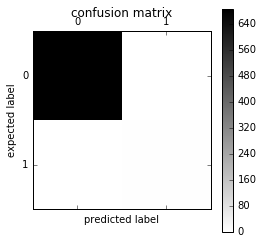

[[686   0]
 [  0   5]]
Standard errors:  [ 96.12861978   1.01765179  50.38927064]
Wald statistics:  [ 1.17622414  1.1657972   1.12094348]
p_val coef 0.28026648812
p_val coef 0.289715389168
p_val intercep 0.278126028348
22.0514289356
0.4082736533
t = 1.07972089096
p_val: 0.28026648812
CI:
-0.895817610538 3.09337740413
===== new fold
Coef: [  0.75045286 -44.78342938]  intercept: -72.140150015
1.0


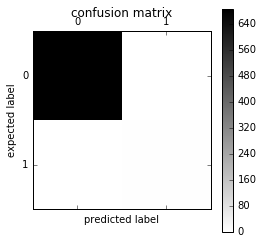

[[686   0]
 [  0   4]]
Standard errors:  [ 70.33998923   0.74179093  44.14060578]
Wald statistics:  [ 1.05183953  1.02349047  1.02933826]
p_val coef 0.311692487649
p_val coef 0.310314141266
p_val intercep 0.305083807317
9.06447635924
0.494871398032
t = 1.01167705946
p_val: 0.311692487649
CI:
-0.703457352123 2.20436307742
===== new fold
Coef: [  1.06927752 -51.74249528]  intercept: -101.430960863
1.0


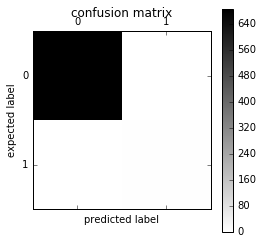

[[686   0]
 [  0   4]]
Standard errors:  [ 93.12645518   0.98662152  48.49030191]
Wald statistics:  [ 1.18630111  1.17457217  1.13863613]
p_val coef 0.27846377128
p_val coef 0.285940704188
p_val intercep 0.276076938826
20.1470063083
0.421261852404
t = 1.08377680634
p_val: 0.27846377128
CI:
-0.86450066144 3.00305570705
===== new fold
Coef: [  0.9718733  -47.05830602]  intercept: -92.2312706086
1.0


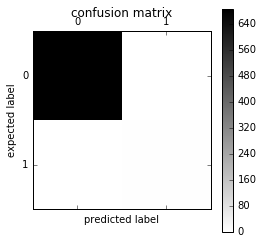

[[686   0]
 [  0   5]]
Standard errors:  [ 82.83934384   0.87725677  43.39042556]
Wald statistics:  [ 1.23960433  1.22734272  1.17620971]
p_val coef 0.26792443956
p_val coef 0.278128976279
p_val intercep 0.265547323634
14.7507890003
0.473525286753
t = 1.10785500689
p_val: 0.26792443956
CI:
-0.74754996387 2.6912965729
===== new fold
Coef: [  1.06067575 -51.46747973]  intercept: -100.64610717
1.0


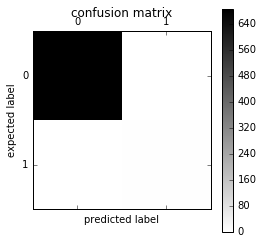

[[686   0]
 [  0   5]]
Standard errors:  [ 91.88555428   0.97279296  48.16521502]
Wald statistics:  [ 1.19977411  1.18884282  1.14182303]
p_val coef 0.275563097529
p_val coef 0.285267441863
p_val intercep 0.273366831906
19.4403333898
0.429128678785
t = 1.09034068985
p_val: 0.275563097529
CI:
-0.845998454483 2.96734994857
===== new fold
Coef: [  0.96021511 -46.47081496]  intercept: -91.1249472454
1.0


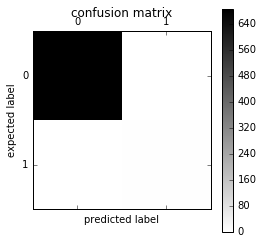

[[686   0]
 [  0   4]]
Standard errors:  [ 81.7359114    0.86563825  42.79428629]
Wald statistics:  [ 1.24293598  1.23045063  1.17920416]
p_val coef 0.267319418583
p_val coef 0.277518072572
p_val intercep 0.264905967882
14.251555671
0.47881745106
t = 1.10925679309
p_val: 0.267319418583
CI:
-0.736435858469 2.65686607065


In [167]:
import scipy
from scipy.stats import chisqprob

def ci_p_val_z_score_scikit(model,X_train):
    # Calculate matrix of predicted class probabilities. 
    predProbs = np.matrix(model.predict_proba(X_train))
    # Design matrix -- add column of 1's at the beginning of your X_train matrix
    X_design = np.concatenate((np.ones( X_train.shape[0]).reshape(X_train.shape[0], 1),
                    X_train[:,:].reshape(X_train.shape[0], 2)),axis=1)
    # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
    V = np.matrix(np.zeros(shape = (X_design.shape[0], X_design.shape[0])))
    #np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1)
    np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1)
    # Covariance matrix
    covLogit = np.linalg.inv(X_design.T * V * X_design)
    #print "Covariance matrix: ", covLogit
    # Standard errors
    sdd=np.sqrt(np.diag(covLogit))
    print "Standard errors: ", sdd
    # Wald statistic (coefficient / s.e.) ^ 2
    logitParams = np.insert(model.coef_[0], 0, model.intercept_[0])
    print "Wald statistics: ", ((logitParams / sdd) ** 2)
    #print "Wald statistics intercept: ", ((logitParams_intercept / sdd** 2)[0]
    wald_score=((logitParams / sdd) ** 2 )
    #wald_score_intercept=((logitParams_intercept / np.sqrt(np.diag(covLogit))) ** 2)[0]
    print "p_val coef",chisqprob(wald_score[1],1)
    print "p_val coef",chisqprob(wald_score[2],1)
    print "p_val intercep",chisqprob(wald_score[0],1)
    #print "p_val intercept",chisqprob(wald_score_intercept,1)

    # upper CI for beta
    print np.exp(model.coef_[0][0]+1.96*sdd[1])
    # lower CI for beta
    print np.exp(model.coef_[0][0]-1.96*sdd[1])
    #print np.exp(mlogit_res_.params[0])
    # critical value of the t-statistic


    i=0
    # the estimated coefficient, and its variance
    beta = model.coef_[0][0]
    se = sdd[1]
    t = beta / se
    print 't =', t

    print "p_val:",2* (1 - scipy.stats.norm.cdf(abs(t)))
    print "CI:"
    # the confidence interval
    print beta - 1.96 * se, beta + 1.96 * se 
    
def predict_model_scikit(X,y):
    X_train=X
    Y_train=y
    model = LogisticRegression(C=1e5)

    skf = cross_validation.StratifiedKFold(Y_train.ravel(), n_folds=10,shuffle=True)
    for train_index,test_index in skf:
        print "===== new fold"
        model = model.fit(X_train[train_index,:],Y_train.ravel()[train_index])
        print "Coef:", model.coef_[0]," intercept:",model.intercept_[0]
        y_true=Y_train.ravel()[train_index]
        y_pred=model.predict(X_train[train_index,:])


        #target_names = ['female',  'neutral']
        #print(classification_report(y_true, y_pred, target_names=target_names))
        print r2_score(y_true, y_pred)

        plt.matshow(confusion_matrix(y_true, y_pred), cmap=plt.cm.binary, interpolation='nearest')
        plt.title('confusion matrix')
        plt.colorbar()
        plt.ylabel('expected label')
        plt.xlabel('predicted label')
        plt.show()

        #print classification_report(y_true, y_pred)
        print confusion_matrix(y_true, y_pred)   
        ci_p_val_z_score_scikit(model,X_train[train_index,:])
        
predict_model_scikit(X,y)        

# full models (all data)

In [168]:
res_female,data_,X_train,Y_train=predict_model(df_df,predict_case="female",train_split=False)
#data.to_csv("de/predict_female.csv")
data_.to_csv("de/predict_female_b.csv")

         Current function value: 0.000000
         Iterations: 35
l_m_without_outliers      9.511698
NormalizedGoogleDif2   -466.847973
intercept              -900.941214
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  767
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                   1.000
Time:                        19:47:12   Log-Likelihood:            -3.5983e-11
converged:                      False   LL-Null:                       -30.149
                                        LLR p-value:                 8.063e-14
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
l_m_

In [106]:
res_male,data2,X_train,Y_train=predict_model(df_df,predict_case="male",train_split=False)

Optimization terminated successfully.
         Current function value: 0.107391
         Iterations 8
l_m_without_outliers    0.002656
NormalizedGoogleDif2    3.449065
intercept               1.297880
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                  0.2277
Time:                        17:38:41   Log-Likelihood:                -82.477
converged:                       True   LL-Null:                       -106.80
                                        LLR p-value:                 2.736e-11
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------

In [107]:
res_n,data3,X_train,Y_train=predict_model(df_df,predict_case="neutral",train_split=False)

Optimization terminated successfully.
         Current function value: 0.105718
         Iterations 8
l_m_without_outliers   -0.002919
NormalizedGoogleDif2   -1.784924
intercept              -2.411276
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                 0.04872
Time:                        17:39:06   Log-Likelihood:                -81.191
converged:                       True   LL-Null:                       -85.349
                                        LLR p-value:                   0.01564
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------

In [ ]:
#perform Bayesian gml in R
#=====>

# predict for training data

In [186]:
res_f,data_,X_train,Y_train=predict_model(df_df,predict_case="female")


613 154 767
         Current function value: 0.000000
         Iterations: 35
l_m_without_outliers      9.589135
NormalizedGoogleDif2   -470.669764
intercept              -908.282898
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  613
Model:                          Logit   Df Residuals:                      610
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                   1.000
Time:                        20:04:59   Log-Likelihood:            -2.9298e-11
converged:                      False   LL-Null:                       -18.952
                                        LLR p-value:                 5.879e-09
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------

In [185]:
#merge train data
X_train["Bias2"]=Y_train
X_train.to_csv("de/predict_female_btrain2.csv")

In [129]:
res_female2,data,X_train,Y_train=predict_model(df_df,predict_case="female",remove="neutral",train_split=False)


         Current function value: 0.000000
         Iterations: 35
l_m_without_outliers     -0.007094
NormalizedGoogleDif2   -213.850792
intercept               -25.734197
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  750
Model:                          Logit   Df Residuals:                      747
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                   1.000
Time:                        18:32:01   Log-Likelihood:            -2.8615e-12
converged:                      False   LL-Null:                       -34.946
                                        LLR p-value:                 6.656e-16
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
l_m_

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [130]:
data.to_csv("de/predict_female_train2.csv")

In [140]:
res_f3,data,X_train,Y_train=predict_model(df_df,predict_case="female",remove="neutral")

600 150 750
         Current function value: 0.000000
         Iterations: 35
l_m_without_outliers      0.186157
NormalizedGoogleDif2   -175.894215
intercept               -32.048449
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Bias2   No. Observations:                  600
Model:                          Logit   Df Residuals:                      597
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                   1.000
Time:                        18:41:18   Log-Likelihood:            -1.6827e-12
converged:                      False   LL-Null:                       -33.601
                                        LLR p-value:                 2.554e-15
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
data.to_csv("de/predict_female_train3.csv")